# Single Atom Laser

Author: Longfei Fan

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
# make qutip available in the rest of the notebook
from qutip import *

## 1. Introduction and model

Consider a single atom coupled to a single cavity mode, as illustrated in the figure below. If there atom excitation rate $r_a$ exceeds the relaxation rate $\gamma$, a population inversion can occur in the atom, and if coupled to the cavity the atom can then act as a photon pump on the cavity.

**Level Diagram**

<img src="figs\levels.png"  width="40%" height="40%">

The coherent dynamics in this model is described by the Hamiltonian

$$
H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)
$$

$$
H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)
$$

where $\omega_0$ is the cavity energy splitting, $\omega_a$ is the atom energy splitting and $g$ is the atom-cavity interaction strength.

In addition to the coherent dynamics the following incoherent processes are also present: 

1. $l$ relaxation and thermal excitations of the cavity,
2. $\gamma$ atomic decay rate
3. $r_a$ atomic excitation rate (pumping process).

The Lindblad master equation for the model is:

$$
\begin{aligned}
\dot{\rho} = &-i~[H, \rho]\\
&+ \gamma (n_{\rm th} + 1) \left(\sigma_-\rho\sigma_+ - \frac{1}{2}\sigma_+\sigma_-\rho - \frac{1}{2}\rho\sigma_+\sigma_-\right) \\
&+ (\gamma n_{\rm th} + r_a) \left(\sigma_+\rho\sigma_- - \frac{1}{2}\sigma_-\sigma_+\rho - \frac{1}{2}\rho\sigma_-\sigma_+\right) \\
&+ l (n_{\rm th} + 1) \left(a\rho a^\dagger - \frac{1}{2}a^\dagger a\rho - \frac{1}{2}\rho a^\dagger a\right) \\
&+ l n_{\rm th} \left(a^\dagger\rho a - \frac{1}{2}a a^\dagger \rho - \frac{1}{2}\rho a a^\dagger\right)
\end{aligned}
$$

in units where $\hbar = 1$.

**Lindblad master equation**

The general form of a Lindblad master equation is given by

$$
\hat{\rho} = - \frac{i}{\hbar} [H, \rho] 
+ \sum_n \left[C_n \rho C^\dagger_n - \frac{1}{2} \rho C^\dagger_n C_n - C^\dagger_n C_n \rho \right],
$$

where the $C_n = \sqrt{\gamma_n} A_n$ are collapse operators, and $A_n$ are the operators through which the environment couples to the system in $H_{\rm int}$.

### Problem parameters

- Cavity frequency: $\omega_c = 2\pi$
- Atom frequency: $\omega_a = 2\pi$
- Coupling strength: $g = 0.05 \times 2\pi$
- atom dissipation rate: $\gamma = 0.01$
- atom pump rate: $r_a = 0.20$
- cavity dissipation rate: $l = 0.02$
- average thermal photon: $n_{\rm th} = 0$

It is operated far above threshold $A = \frac{2 r_a g^2}{\gamma^2} = 2 \times 0.2 \times \left( \frac{0.314159}{0.01} \right)^2 = 394.8 \gg l = 0.02$. And $B = \frac{4 g^2}{\gamma^2} A$. The average photon number of stable state is $\frac{A^2}{BC} = \frac{r_a}{2l} = 5.$


In [48]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.02 * 2 * np.pi  # coupling strength

l = 0.01        # cavity dissipation rate
gamma = 0.01    # atom dissipation rate
ra = 0.4       # atom pump rate

use_rwa = True

N = 60          # truncted number of cavity fock states
n_th_a = 0.0      # avg number of thermal bath excitation

In [49]:
ra, l, gamma, g

(0.4, 0.01, 0.01, 0.12566370614359174)

In [50]:
A = 2 * ra * (g / gamma) ** 2
A

126.33093633394378

In [51]:
B = 4 * g**2 * A / gamma**2
B

79797.5273750548

In [52]:
n_a = ra / 2 / l
n_a

20.0

In [53]:
A * (A - l) / B / l

19.99841685650559

### Setup the operators, the Hamiltonian and initial state

In [54]:
# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), sigmam())
sz = tensor(qeye(N), sigmaz())

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + 0.5 * wa * sz + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a + 0.5 * wa * sz + g * (a.dag() + a) * (sm + sm.dag())

### Create a list of collapse operators that describe the dissipation

In [55]:
# collapse operators
c_ops = []

rate = l * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

rate = l * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

rate = gamma * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

rate = gamma * n_th_a + ra
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm.dag())

### Evolve the system

Here we evolve the system with the Lindblad master equation solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_+\sigma_-$ are returned by the solver by passing the list `[a.dag()*a, sm.dag()*sm]` as the fifth argument to the solver.

In [56]:
# timestamp
tmax = 400
npoints = tmax * 2 + 1
tlist = np.linspace(0, tmax, npoints)

# intial state
psi0 = tensor(fock(N, 0), basis(2, 1)) # start without excitations

In [57]:
opt = Options(nsteps=2500) # allow extra time-steps 
%time output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm], options=opt)
# %time output = mesolve(H, psi0, tlist, c_ops, [], options=opt)

CPU times: user 12.8 s, sys: 264 ms, total: 13.1 s
Wall time: 3.23 s


In [58]:
# steady_output = output.states[800]
# steady_field = steady_output.ptrace(0)

In [59]:
# steady_field

## 2. Visualize the motion

Here we plot the excitation probabilities of the cavity and the atom (these expectation values were calculated by the `mesolve` above).

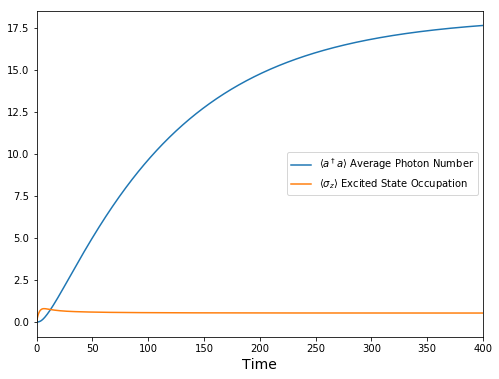

In [60]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8,6))

axes.plot(tlist, n_c, label=r'$\left< a^\dagger a \right>$ Average Photon Number')
axes.plot(tlist, n_a, label=r'$\left< \sigma_z \right>$ Excited State Occupation')
axes.set_xlim(0, tmax)
axes.legend(loc=5)
axes.set_xlabel('Time', fontsize=14)
# axes.set_ylabel('Probability', fontsize=14)
# axes.set_xlim(0, 20)

## 3. Photon statistics and wigner function

### Steady State

In [61]:
%time rho_ss = steadystate(H, c_ops)

CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 184 ms


In [ ]:
plot_wigner_fock_distribution(ptrace(rho_ss, 0), alpha_max=10, 
                              figsize=(10,4), colorbar=True)

(<matplotlib.figure.Figure at 0x7f227ea83e50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f227eadcf90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f227e8dc0d0>], dtype=object))

(<matplotlib.figure.Figure at 0x7fa5d087a6d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa5c37210d0>)

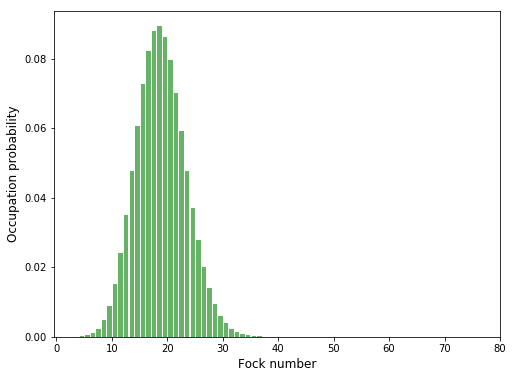

In [232]:
# fig, axes = plt.subplots(1, 1, figsize=(6,4))
plot_fock_distribution(ptrace(rho_ss, 0), unit_y_range=False)
# axes.set_ylim(0, 0.04);

CPU times: user 2.49 s, sys: 8 ms, total: 2.5 s
Wall time: 2.5 s


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fa5d1fa6f10>)

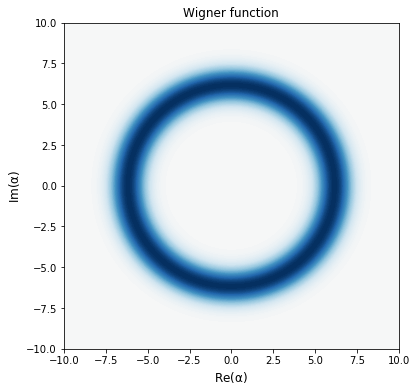

In [197]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))
%time plot_wigner(ptrace(rho_ss, 0), ax=axes, alpha_max=10, method='clenshaw')
# axes.set_ylim(-20, 20)
# axes.set_xlim(-20, 20)

### Wigner function for $\big\lvert \alpha = \sqrt{5} \big\rangle$

(<matplotlib.figure.Figure at 0xe3bce80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x166c92b0>)

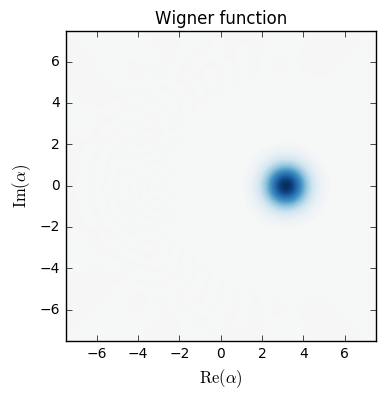

In [70]:
plot_wigner(coherent(N, np.sqrt(5)), figsize=(4,4))

### As a function of time

In [72]:
tlist2 = np.linspace(0, 80, 5)
output = mesolve(H, psi0, tlist2, c_ops, [], options=Odeoptions(nsteps=2500))

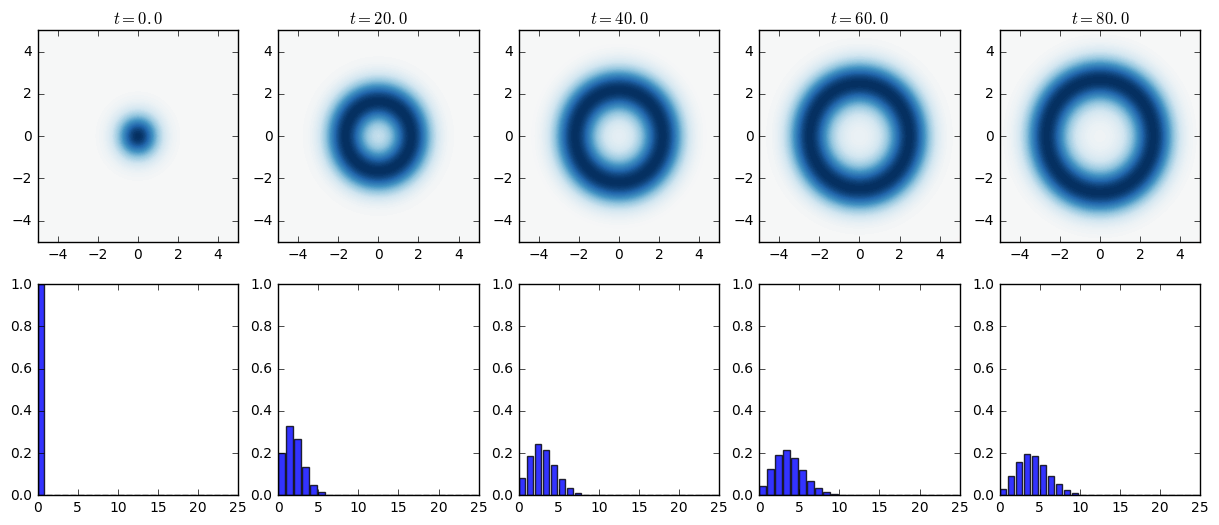

In [73]:
rho_ss_sublist = output.states

xvec = np.linspace(-5,5,200)

fig, axes = plt.subplots(2, len(rho_ss_sublist), figsize=(3*len(rho_ss_sublist), 6))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)
    
    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)
    
    # plot its wigner function
    wlim = abs(W).max()
    axes[0,idx].contourf(xvec, xvec, W, 100, 
                         norm=mpl.colors.Normalize(-wlim,wlim), 
                         cmap=plt.get_cmap('RdBu'))
    axes[0,idx].set_title(r'$t = %.1f$' % tlist2[idx])
    
    # plot its fock-state distribution
    axes[1,idx].bar(np.arange(0, N), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.8)
    axes[1,idx].set_ylim(0, 1)
    axes[1,idx].set_xlim(0, N/2)

## 4. von Neumann Entropy

In [73]:
opt = Options(nsteps=2500) # allow extra time-steps 
output2 = mesolve(H, psi0, tlist, c_ops, [], options=opt)

In [74]:
states = output2.states

entropy_cavity = np.zeros(shape(states))
entropy_atom   = np.zeros(shape(states))

for idx, rho in enumerate(states):
    
    rho_cavity = ptrace(rho, 0)
    entropy_cavity[idx] = entropy_vn(rho_cavity, 2)

    rho_atom = ptrace(rho, 1)
    entropy_atom[idx] = entropy_vn(rho_atom, 2)

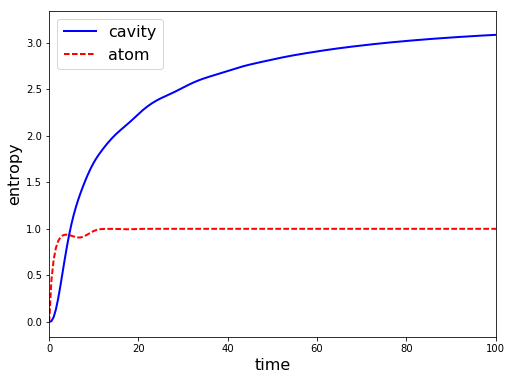

In [91]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
axes.plot(tlist, entropy_cavity, 'b', label="cavity", linewidth=2)
axes.plot(tlist, entropy_atom, 'r--', label="atom", linewidth=2)
# axes.set_ylim(0,1)
axes.set_ylabel("entropy", fontsize=16)
axes.set_xlabel("time", fontsize=16)
axes.legend(loc=2, fontsize=16)
axes.set_xlim(0, 100);

### Software version

In [77]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.1.0
Numpy,1.11.3
SciPy,0.18.1
matplotlib,2.0.0
Cython,0.25.2
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux2]
